In [47]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.data import words_clusters
from src.utils import cluster_search
from src.data.words_clusters import cluster_space
from src.data.words_clusters import cluster_communism




# DATA LOADING

In [42]:
import import_ipynb
import results

df_movies_tmdb_ratings_unique = results.df_movies_tmdb_ratings_unique
df_movies_tmdb_ratings = results.df_movies_tmdb_ratings
df_plots = results.df_plots


# Movies General Basic Statistics

To start the analysis, some general information about the dataframe are retrieved. First, the movies distribution by release date is plotted.

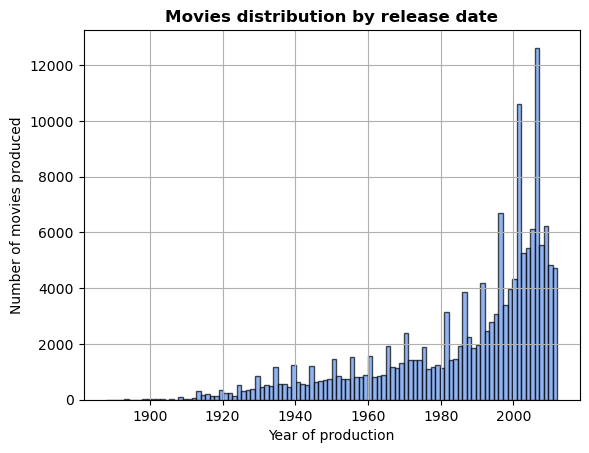

In [3]:
# Movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_tmdb_ratings['release_date'], bins= 100, edgecolor='black', alpha=0.7, color='cornflowerblue')
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that the number of movies producd each year steeply increases over time.

CHECK IF EXPONENTIAL??

Other numerical parameters are then analysed. In the dataframe, runtime, release date and revenue all present numerical values. The distributions of these attributes are plotted over time.

In [4]:
# Conversion of the revenue column in numerical data
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

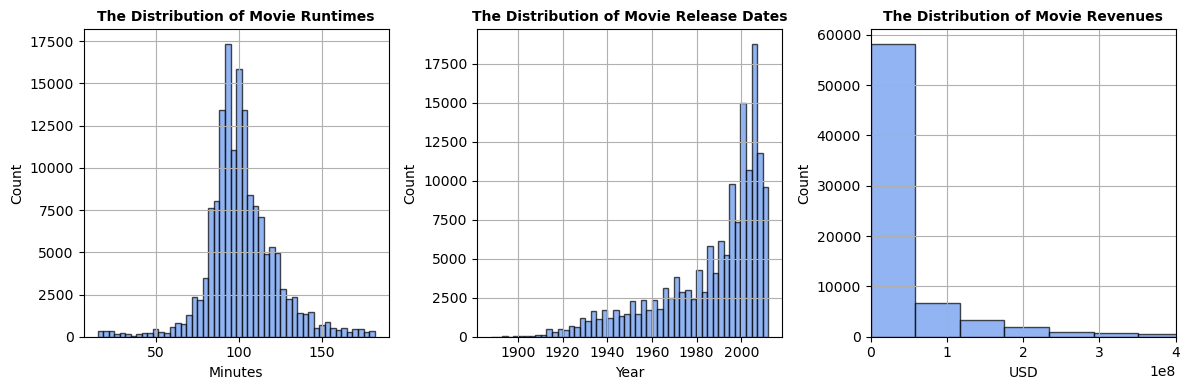

In [5]:
# Standard font for plots
hfont = {'fontname':'sans-serif'}

# Plot the three distributions
fig, ax = plt.subplots(1, 3,figsize= (12,4), sharey = False, sharex = False)

# Labels
quantities = ['runtime', 'release_date', 'revenue']
quantities_x = ['Minutes', 'Year', 'USD']

# Distribution of runtime plot
sbplt = ax[0]
sbplt.hist(df_movies_tmdb_ratings[quantities[0]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Runtimes", **hfont, weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[0], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.grid(True)

# Distribution of release dates plot    
sbplt = ax[1]
sbplt.hist(df_movies_tmdb_ratings[quantities[1]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Release Dates", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[1], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.grid(True)

# Distribution of revenues plot
sbplt = ax[2]
sbplt.hist(df_movies_tmdb_ratings[quantities[2]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Revenues", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[2], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.set_xlim([0, 0.4e9])
sbplt.grid(True)

fig.tight_layout()

From the graphs above, some hypothesis regarding the types of distribution can be done. The shape of the distribution of movie runtime suggest a normal distribution, while the movie revenue looks exponential.

In [6]:
# Testing if the runtime is normally distributed
diagnostic.kstest_normal(df_movies_tmdb_ratings['runtime'].values, dist = 'norm') 

(0.08834966523957095, 0.0009999999999998899)

Although the runtime normality test returns a low p-value, leading us to reject the null hypothesis that the data is normally distributed, the histogram above shows a roughly bell-shaped plot for movie runtime. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a Q-Q plot is employed to further assess normality.

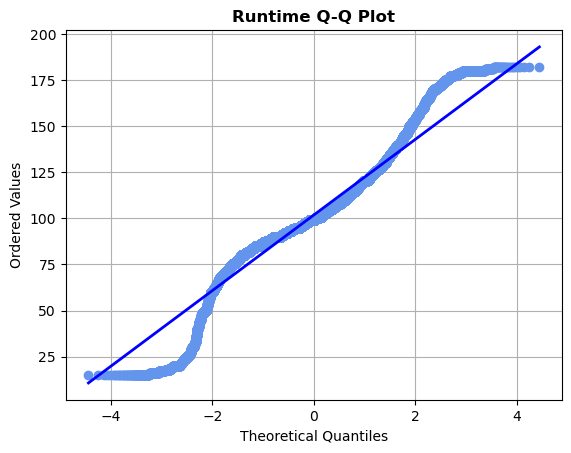

In [7]:
# Setting up the figure
fig, ax = plt.subplots()

# Q-Q plot
res = stats.probplot(df_movies_tmdb_ratings['runtime'].values, dist="norm", plot=ax)

# Line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

# Plot settings 
plt.title("Runtime Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

plt.show()

The steep increases near the plot's edges indicate at runtime values at the extremes of our distribution, there are less values than expected if the plot were to follow a normal trend. The opposite is true for the flatter region of the plot near the center of the theoretical quantiles, indicating we have more runtimes close to the mean of the distribution than expected if there runtimes were normal. So, the runtime data is approximately normal but with a more datapoints more aggregated towards the distribution's mean.

Now, the revenue distribution is tested, to check if it is exponential.

In [22]:
diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['revenue'].dropna().values, dist = 'exp') 

(0.32266192699617324, 0.0009999999999998899)

Similarly to the runtime normality test, the revenue exponential test returns a low p-value, leading us to reject the null hypothesis that the data is exponentially distributed. However, the histogram above shows a roughly power-law plot for movie revenue. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >150K entries. Therefore, a complementary cumulative density function of the revenue data is prepared.

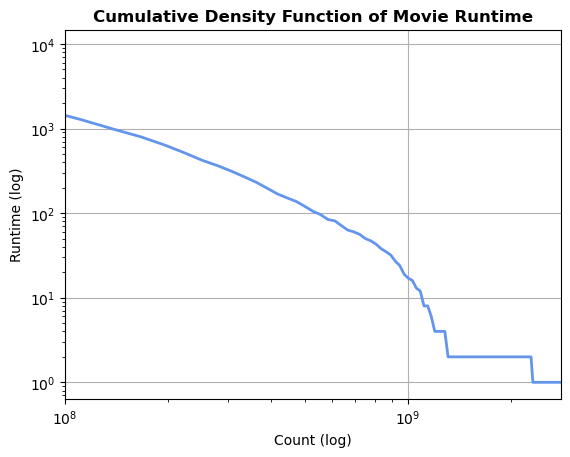

In [20]:
# Setting up the figure
fig, ax = plt.subplots()

# Cumulative density function plot
array_cumulative=plt.hist(df_movies_tmdb_ratings_unique['revenue'].values,bins=100,log=True,cumulative=-1,histtype='step', visible=False)
plt.loglog(array_cumulative[1][1:],array_cumulative[0])

# Line settings
line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

# Plot settings 
plt.title('Cumulative Density Function of Movie Runtime', weight='bold')
plt.xlabel('Count (log)')
plt.ylabel('Runtime (log)')
ax.set_xlim(1e8, max(array_cumulative[1][1:]))
plt.grid(True)
plt.show()


The CCDF of runtime is approximately linearly decreasing, indicative the runtime data to be approximately power law distributed.

Now, possible correlations between these attributes are analysed. First, some plots are used to better visualize relationships.

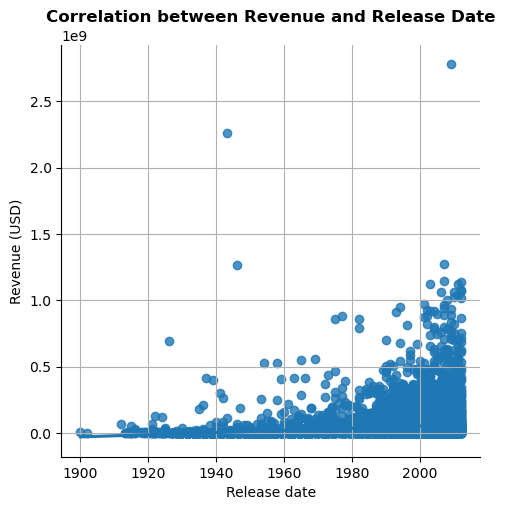

In [19]:
# Scatter-plot to assess possible regressions between release date and revenue
sns.lmplot(x='release_date', y='revenue', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Revenue and Release Date', weight='bold')
plt.xlabel("Release date")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.show()

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

The same scatter plot is used to assess a possible correlation between runtime and revenue.

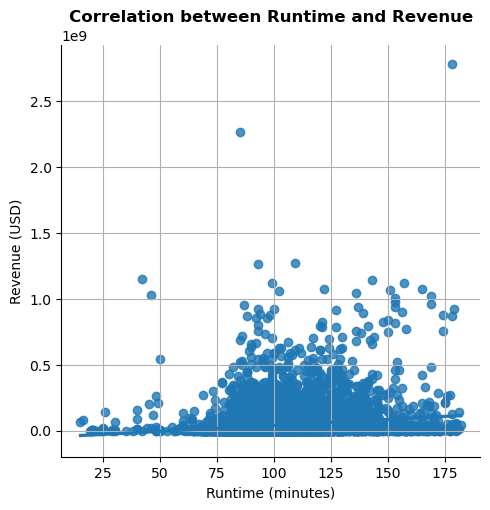

In [18]:
# Scatter-plot to assess possible regressions between runtime and revenue
sns.lmplot(x='runtime',y='revenue', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Runtime and Revenue', weight='bold')
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.show()

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

The last combination is analysed: Runtime and Release Date.

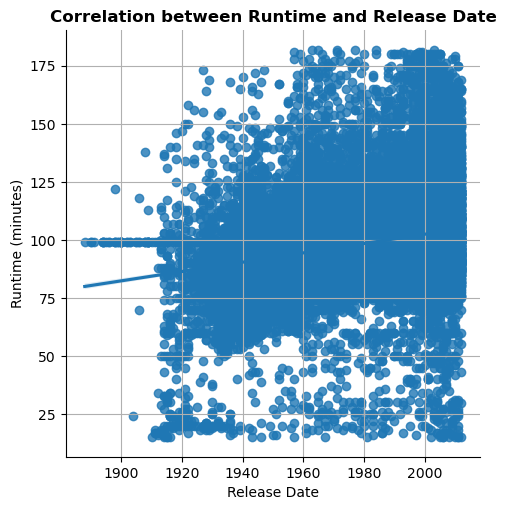

In [17]:
# Scatter-plot to assess possible regressions between runtime and release date
sns.lmplot(x='release_date',y='runtime', data=df_movies_tmdb_ratings_unique)
plt.title('Correlation between Runtime and Release Date', weight='bold')
plt.xlabel("Release Date")
plt.ylabel("Runtime (minutes)")
plt.grid(True)
plt.show()

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

# Movies Genres Analysis

First, the number of unique genres has to be displayed.

In [13]:
# Printing the number of unique genres
print("The number of different genres is:")
print(len(df_movies_tmdb_ratings['genres'].unique()))
print('\n')

The number of different genres is:
156




The number of different genres is more than 100. For the sake and clarity of the analysis, it is ideal to study a limited number of genres. Therefore, the code below estimates the percentage of the movies that would be considered, if the analysis only included n genres.

In [ ]:
# Choosing the number of relevant genres
n = 20

# Selecting the n most relevant genres
genres_counts = df_movies_tmdb_ratings.groupby("genres").size()
genres_counts = genres_counts.sort_values(ascending=False)
genres_top = genres_counts.head(n)

top_genres_count = genres_top.sum()
all_genres_count = genres_counts.sum()

print(f"The top 20 basic genres in the movies dataset account for {round(top_genres_count/all_genres_count * 100)}% of all movie genres.")

# Creating a new dataset, containing only movies from the relevant genres
top_genres = genres_top.index.tolist()
df_movies_tmdb_ratings_genres_filtered = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_genres)].copy()

# Printing the number of movies per genre
print('\n Number of movies per genre:')
print(df_movies_tmdb_ratings_genres_filtered['genres'].value_counts())

The top 20 basic genres in the movies dataset account for 68% of all movie genres.

 Number of movies per genre
genres
Drama               20530
Comedy               9663
Thriller             8221
Romance Film         7436
World cinema         7140
Action               5803
Crime Fiction        5414
Indie                4791
Action/Adventure     4545
Horror               3973
Adventure            3801
Black-and-white      3528
Romantic drama       3328
Mystery              2876
Fantasy              2639
Period piece         2582
Family Film          2527
Science Fiction      2502
Crime Thriller       2469
Film adaptation      2276
Name: count, dtype: int64


Almost 70% of the total number of movies is described, if the analysis focuses more on 20 "relevant", or most common, genres. Regarding the number of movies per genre, every genre has more than 2'000 movies. Drama, the most present genre, has more than 20'000 movies.

From the loading and cleaning section, it is clear that many movies have more than 1 genre. Having multiple genres can be defined as 'genres complexity' and this feature is studied over time, in order to see the genres complexity distribution based on the release date of the movie.

In [ ]:
# count the number of genres for each film
unique_genres_count = df_movies_tmdb_ratings.groupby('title')['genres'].nunique()
unique_genres_count = unique_genres_count.to_frame()
unique_genres_count = unique_genres_count.reset_index()

unique_genres_count = unique_genres_count.rename(columns={"genres": "genres_count"}) 
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb_ratings, unique_genres_count, left_on='title', right_on='title')

mean_genres_per_year = df_movies_tmdb_ratings.groupby('release_date')["genres_count"].mean()

# visualizing if more than one genre being given to a film has increased over years
fig, ax = plt.subplots()

mean_genres_per_year.plot(kind='line')  

line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

plt.title("Movie Genre Complexity Across Time", **hfont, weight='bold', fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Average Genres Assigned to Movies", fontsize=10)
plt.grid(True)
plt.show()

KeyError: 'Column not found: genres_count'

It is evident that there are some fluctuations, but the genres complexity does not drastically increase over time. Instead, the first movies, from 1900 to 1930, generally present much higher genres complexity. This figure produced per country and then across time period worldwide and per country would be interesting.

The plot below focus on the distribution of movies in time, divided per genre. Only the most relevant genres are displayed. The objective is to find particular or evident trends to study. Note that, to better visualize the graphs, the y-axis range changes between graphs.

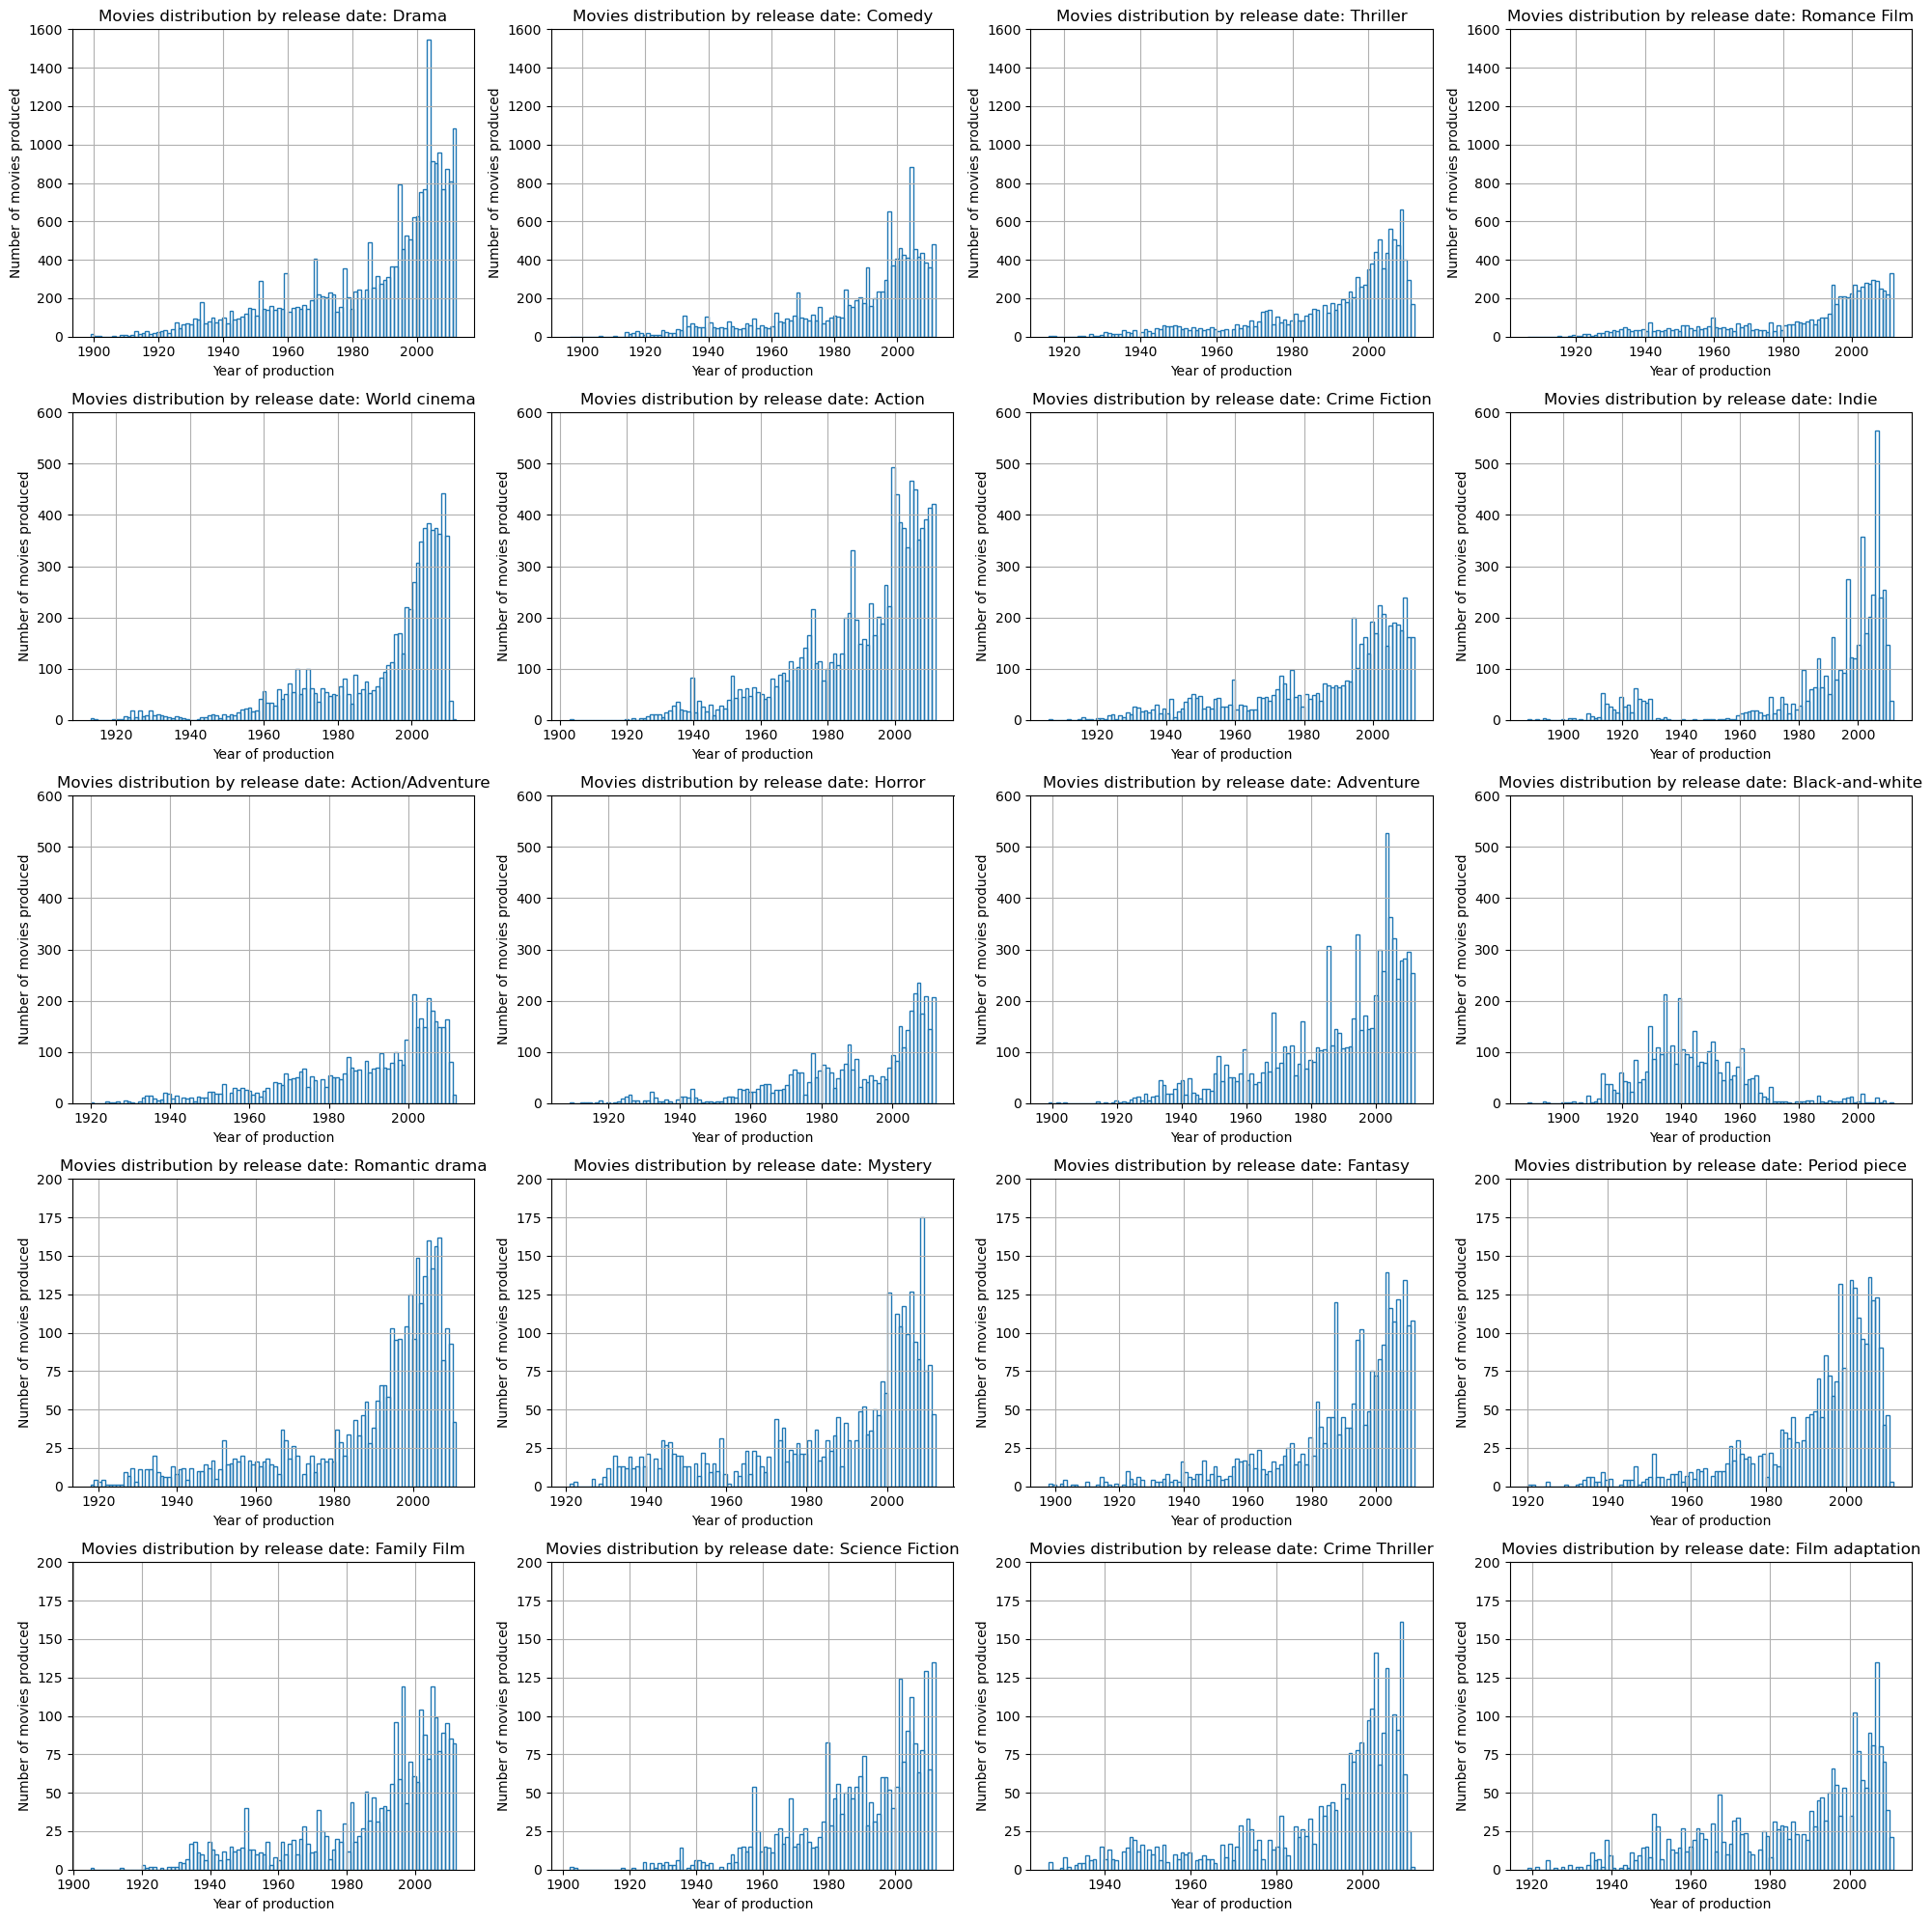

In [39]:
# Number of rows and columns for subplots
n_rows = 5
n_cols = 4

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Loop over the top 20 genres
for i, genre in enumerate(top_genres[:20]):
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # Genre filtering
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    # Plot the histogram for the current genre
    ax.hist(genre_movies['release_date'], bins=100, **style)

    # Labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    # Set y-limits
    if i <= 3:
        ax.set_ylim(0, 1600)  
    if i > 3 and i <= 11:
        ax.set_ylim(0, 600)
    if i >= 12:
        ax.set_ylim(0, 200)
    
    ax.grid(True)

plt.tight_layout()
plt.show()

Apart from the general increasing trend, probably also caused by the general increase in movies production over the last decades, some particular trends can be highlighted. For example, the indie genre seems to disappear between the 1940 and 1960. Adventure movies and drama movies present many peaks, that seem evenly paced at first glance. 

Many meaningful themes for the analysis, for example the 'Space exploration' theme, are not classified as genres. Thus, the plots are used to idetify common words and create new 'genres', definitely plot related.

In [52]:
# Counting space clusters entries occurances in 'plot_summary'
df_plots['space'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_space))

n_space = 3
df_plots_space = df_plots[df_plots['space'] > n_space]
df_plots = df_plots.drop(columns=['space'])

print('Number of movies that present the Space theme: ', len(df_plots_space))

Number of movies that present the Space theme:  198


The same reasoning can be applied to the communism theme, meaningful for more historical related analysis.

In [51]:
# Counting communism clusters entries occurances in 'plot_summary'
df_plots['communism'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_communism))

n_communism = 2
df_plots_communism = df_plots[df_plots['communism'] > n_communism]
df_plots = df_plots.drop(columns=['communism'])

print('Number of movies that present the Space theme: ', len(df_plots_communism))

Number of movies that present the Space theme:  95
